-------------------------------------------
<div>
<img src="https://www.bournemouth.ac.uk/sites/all/themes/bournemouth/assets/images/logo-horizontal.svg" width="400"/>
</div>


-----------------------------------------------

 

| Faculty of Science and Technology           |
| :-----------------------------------------: | 
| Department of Computing and Informatics     |
| Search and Optimisation Assignment - 2020/21 |
| Group 30 |
| Names: Johnson G Oyeniyi, Samuel O Adekunle, Nikhil Chandrannola, Venkata Sujith Reddy Chevuru, Abhinash Chilakala |










## **Problem Definition** 
---



We have been employed by **SaO Gas Ltd** as **data scientists**. We are to produce delivery schedules for their fleet of **25 tanker lorries** operating from **4 depots** in the country of Optilandia (which surprisingly use £ as their currency), minimising the overall cost of delivery for the distributor under certain constraints.
SaO Gas Ltd operates three types of tanker as shown in the table below.

| Tanker type|Capacity tonnes|Cost per mile[£]|Cost per mile per[£] |
| :-----------------------------------------: | || |
| Small     |5 |1.00| 1.50|
| Medium |12 |1.50| 1.00|
|Large | 22 | 2.0 | 0.5|



As an example, a large tanker can be loaded with up to 22 tonnes of LPG at one of the depots (you can
assume that depots never run out of gas). It costs the distributor £2 per mile to use the large tanker (even
if it is empty) plus £0.50 per mile for every tonne of LPG the tanker carries. So, a large tanker with 10
tonnes of LPG travelling 20 miles costs: 20 [miles] x (2.00 [£] + 10 [tonnes] x 0.50 [£]) = 140 [£]. 


### **Problem 1** 
---


We are to schedule LPG delivery **to all customers** in order to fully fill their tanks while **minimising the overall cost of delivery**. There are no additional constraints apart from the tanker lorry capacity – a lorry can for example visit any of the depots multiple times in order to load additional gas.

### **Problem 2** 
---

We are to schedule LPG delivery in order to **maximise the amount of gas delivered** to the customers, while **minimising the overall cost of delivery** (including any potential penalties! - see below) and while observing the following constraints in addition to tanker lorry capacity:
- Each lorry can travel up to 250 miles
- Each lorry can only stop up to 5 times, this includes customer deliveries and any additional visits to the depot
- Each lorry must end its journey in one of the depots (this doesn’t count towards the 5 stop limit and doesn’t have to be the depot from which the lorry started its journey)
- If you don’t deliver to customers who have less than 15% of gas in their tanks, SaO Gas Ltd will incur a penalty of £1,000 for each such customer

### Modules Import
Here, we import the necessary libraries for the programming task

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

In [3]:
import json
import networkx as nx
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

%matplotlib inline



## Loading the data


The dataset for this assignment consists of three files which can be accessed from the links below:
1. [***SaO_Optilandia_locations.csv***](https://livebournemouthac-my.sharepoint.com/:x:/g/personal/mbudka_bournemouth_ac_uk/EVxDsrDCWYxLmonoGcnecvMBADG1N1xcMI9PA_xdCu80JA?e=5SgYyc)
2. [***SaO_Optilandia_links.csv***](https://livebournemouthac-my.sharepoint.com/:x:/g/personal/mbudka_bournemouth_ac_uk/EXuI2jqQ6BhGrCM0cuyquykBXzrPYrDMFu0nYruIE7WNFA?e=FnzKO1)
3. [***SaO_Optilandia_depot_lorries.json***](https://livebournemouthac-my.sharepoint.com/:u:/g/personal/mbudka_bournemouth_ac_uk/EWtzDsArNalLpydAuA1lsUIBgTsshadY3FTuO0HeUtPsOQ?e=VrOzyH)


Once downloaded put these in the working directory (folder where the notebook is being run from)

In [4]:

df_link = pd.read_csv(r'SaO_Optilandia_links.csv')
df_loc = pd.read_csv(r'SaO_Optilandia_locations.csv')

with open('SaO_Optilandia_depot_lorries.json', 'r') as f:
    depot_lorries = json.load(f)

The code below can be used alternatively to import file into google colab

In [346]:
# This code is for usage on google colab
from google.colab import files
uploaded = files.upload()

Saving SaO_Optilandia_depot_lorries.json to SaO_Optilandia_depot_lorries (4).json
Saving SaO_Optilandia_example_solution.json to SaO_Optilandia_example_solution (2).json
Saving SaO_Optilandia_links.csv to SaO_Optilandia_links (4).csv
Saving SaO_Optilandia_locations.csv to SaO_Optilandia_locations (4).csv


In the cell below, I loaded two *.csv* files using `pandas` into DataFrames named `df_loc` and `df_link`:

In [453]:
# This code is for usage on google colab

import io

df_loc = pd.read_csv(io.BytesIO(uploaded['SaO_Optilandia_locations.csv']))
df_link = pd.read_csv(io.BytesIO(uploaded['SaO_Optilandia_links.csv']))

df_loc = pd.read_csv("SaO_Optilandia_locations.csv")

Checking the location dataset

In [166]:
df_loc[df_loc['id'] == 5]


,id,x,y,is_depot,is_customer,capacity,level
5,5,49757.7778,6353.3333,False,True,0.5,0.4


Calculating the length of the locations shows the data has 634 rows


In [58]:
loc_len = len(df_loc)
loc_len

634

The dataset shows that we have 123 customers and 4 depots

In [7]:
len(df_loc[df_loc["is_customer"] == True])

123

In [8]:
len(df_loc[df_loc["is_depot"] == True])

4

Checking the link dataset

In [9]:
df_link.head()

,id1,id2
0,0,483
1,0,117
2,0,497
3,0,224
4,1,388


I now load the *.json* file using the Python `json` standard library into `depot_lorries` variable to understand details of each lorry's capacity:

In [10]:
with open("SaO_Optilandia_depot_lorries.json", 'r') as f:
  data = json.load(f)

In [11]:
data

{'523': [{'lorry_id': '523-0', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
  {'lorry_id': '523-1', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
  {'lorry_id': '523-2', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
  {'lorry_id': '523-3', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
  {'lorry_id': '523-4', 'capacity': 22, 'cpm': 2.0, 'cptm': 0.5}],
 '124': [{'lorry_id': '124-0', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
  {'lorry_id': '124-1', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
  {'lorry_id': '124-2', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
  {'lorry_id': '124-3', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
  {'lorry_id': '124-4', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
  {'lorry_id': '124-5', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
  {'lorry_id': '124-6', 'capacity': 22, 'cpm': 2.0, 'cptm': 0.5},
  {'lorry_id': '124-7', 'capacity': 22, 'cpm': 2.0, 'cptm': 0.5}],
 '373': [{'lorry_id': '373-0', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
  {'lorry_id': '373-1', 'capacity': 5, 'cpm': 1.0, 'cptm': 

## Network visualisation

I use `networkx` library to create a plot showing the road map of *Optilandia*.

I calculate the Euclidean distance between all pairs of nodes in the network using the `x,y` cooridnates in `df_loc` and the `pdist`/`squareform` functions from `scipy.spatial.distance`. I then put the distance matrix in the `dist_eucl` variable: I therefore calculated, for example, the distance between loc 0 and loc 3 which gives me 346

In [12]:
dist_eucl = squareform(pdist(df_loc[['x', 'y']]))
dist_eucl.shape
dist_eucl[0,3]


346.0147808160961

Here, we are to construct network edge objects, to be use in the call to nx.Graph().add_weighted_edges_from() call:

In [13]:
edges  = [(id1,id2,dist_eucl[id1,id2]) for _,(id1,id2) in df_link.iterrows()]
# edges

In the cell below create the network graph using the networkx library (put it in the variable called G):

In [14]:
G = nx.Graph()
G.add_nodes_from(df_loc['id'].to_numpy())
G.add_weighted_edges_from(edges)
pos = {k:v.values for k,v in df_loc[['x','y']].iterrows()}

Let's now plot the network which contain location identifiers for depots and customers respectively

In [15]:
depot_loc_ids, cust_loc_ids = np.where(df_loc.is_depot)[0], np.where( df_loc.is_customer)[0]

depot_loc_ids contains location id of the 4 depots

In [16]:
depot_loc_ids
    

array([116, 124, 373, 523])

cust_loc_ids contains the location id of the 123 customers

In [17]:
cust_loc_ids

array([  5,   8,  13,  14,  22,  27,  29,  31,  32,  36,  41,  44,  63,
        64,  65,  70,  73,  77,  78,  80,  82,  86,  94, 100, 103, 105,
       110, 113, 118, 130, 135, 136, 144, 146, 147, 160, 169, 171, 172,
       175, 177, 180, 183, 190, 200, 202, 204, 205, 206, 210, 214, 216,
       220, 225, 235, 243, 245, 254, 255, 257, 260, 264, 265, 270, 271,
       274, 276, 294, 308, 324, 332, 337, 362, 364, 372, 374, 377, 378,
       380, 387, 389, 391, 393, 397, 398, 400, 408, 411, 418, 431, 437,
       446, 449, 453, 455, 459, 474, 476, 491, 497, 507, 511, 519, 520,
       528, 531, 534, 539, 542, 543, 547, 550, 566, 569, 584, 585, 598,
       603, 606, 621, 624, 632, 633])

Let's now plot the graph again, this time including the depots (in red, with labels denoting location ids) and customers (in green).

In [18]:
def show_network():
   plt.figure(figsize=(20,10))
   nx.draw(G,with_labels=False,pos=pos,node_size=50)

   nx.draw_networkx_nodes(G,pos,nodelist=depot_loc_ids,node_color='r',node_size=600,alpha=1);
   nx.draw_networkx_labels(G,pos,{k:k for k in depot_loc_ids});
   nx.draw_networkx_nodes(G,pos,nodelist=cust_loc_ids,node_color='g',node_size=100,alpha=1);

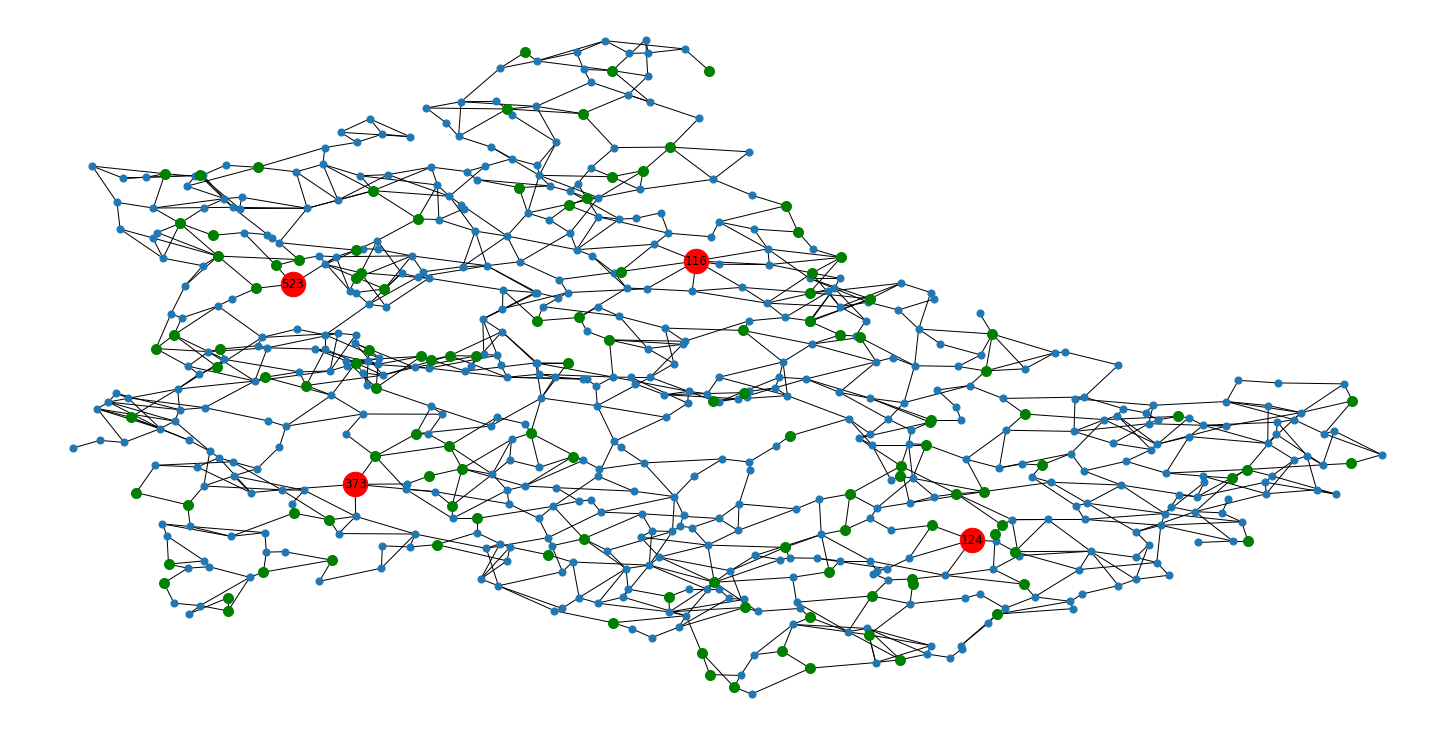

In [19]:
show_network()

Let's consider the distance between two nodes in the network: 116 and 260. One of these happen to be depot while the other is customer's location:

In [20]:
id1, id2 = 116, 260 

In [21]:
df_loc.loc[[id1]]

,id,x,y,is_depot,is_customer,capacity,level
116,116,49804.1667,6253.8889,True,False,NaN,NaN


In [22]:
df_loc.loc[[id2]]

,id,x,y,is_depot,is_customer,capacity,level
260,260,49923.3333,5872.2222,False,True,2.0,0.38


The data shows the distance between `depot 116` and `customer 260` is `399`

In [23]:
distance = dist_eucl[id1,id2]
distance

399.8376526097174

Using dijkstra_path algorithm, i calculate the shortest path between  `depot 116` and `customer 260` and i stored it in a variable call path

In [24]:
path = nx.dijkstra_path(G,id1,id2)
path

[116,
 484,
 447,
 90,
 528,
 437,
 459,
 613,
 64,
 313,
 292,
 537,
 432,
 509,
 147,
 397,
 476,
 384,
 409,
 565,
 354,
 298,
 633,
 260]

In [25]:
edge_list = []
for i in range(len(path) - 1):
  edge_list.append([path[i], path[i + 1]])

Showing on the network the shortest path between  `depot 116` and `customer 260`:

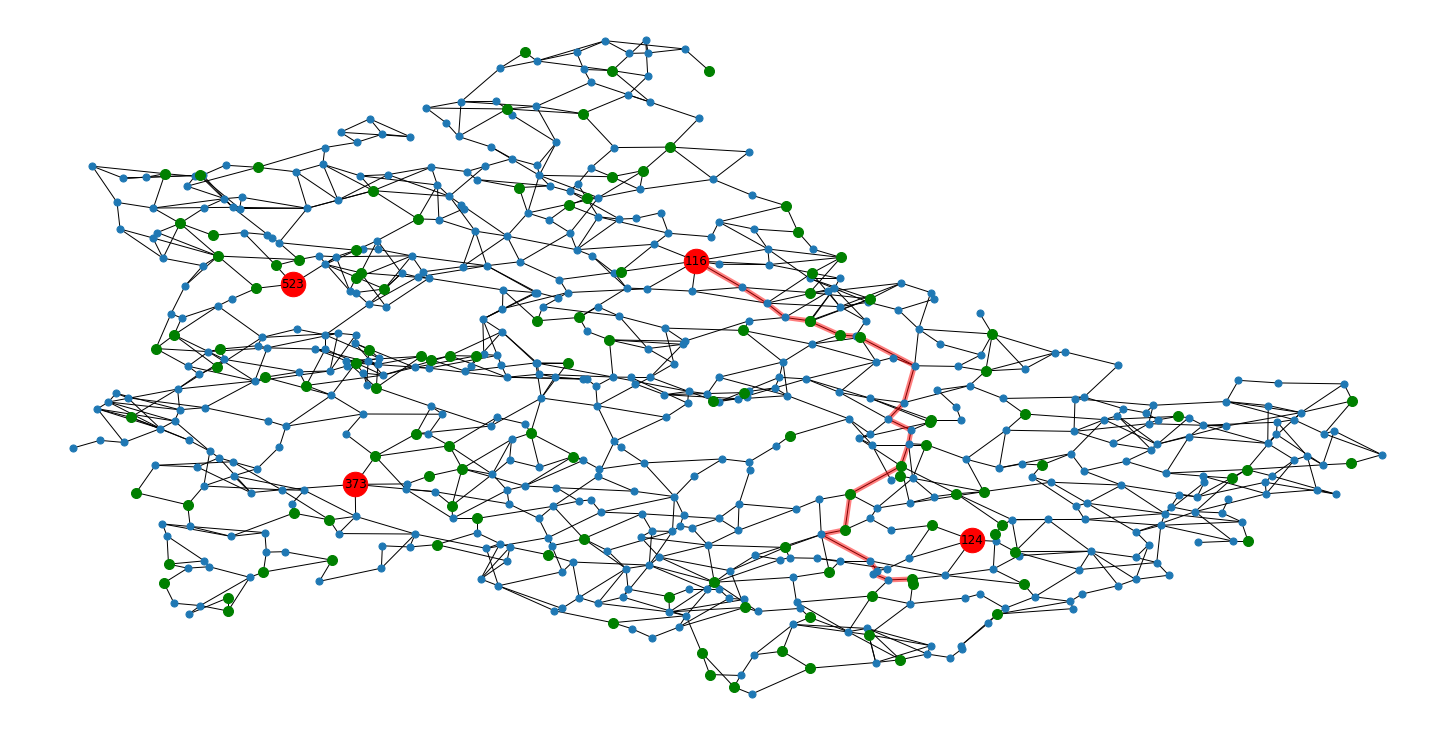

In [28]:
show_network()
nx.draw_networkx_edges(G,pos,edge_list,edge_color='r',width=5.0,alpha=0.5)

In [206]:
graph = {}
for i in range(loc_len):
    graph[df_loc['id'][i]] = {}
df_link_len = len(list(df_link['id1']))
for i in range(loc_len):
    for j in range(df_link_len):
        if df_link['id1'][j] == df_loc['id'][i]:
            graph[df_loc['id'][i]][df_link['id2'][j]] = dist_eucl[df_loc['id'][i]][df_link['id2'][j]]
#             print(df_link['id2'][j])
            graph[df_link['id2'][j]][df_loc['id'][i]] = dist_eucl[df_loc['id'][i]][df_link['id2'][j]]
        
# graph

# Problem 1

Schedule LPG delivery **to all customers** in order to fully fill their tanks while **minimising the overall cost of delivery**. There are no additional constraints apart from the tanker lorry capacity – a lorry can for example visit any of the depots multiple times in order to load additional gas.

Getting details of each lorry just like I did earlier

In [35]:
with open("SaO_Optilandia_depot_lorries.json", 'r') as f:
  depot_lorries = json.load(f)

In [84]:
lorries_flat = []
for _,v in depot_lorries.items():
    lorries_flat += v
lorries_dict = {l['lorry_id']:l for l in lorries_flat}
lorries_dict

{'523-0': {'lorry_id': '523-0', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
 '523-1': {'lorry_id': '523-1', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
 '523-2': {'lorry_id': '523-2', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
 '523-3': {'lorry_id': '523-3', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
 '523-4': {'lorry_id': '523-4', 'capacity': 22, 'cpm': 2.0, 'cptm': 0.5},
 '124-0': {'lorry_id': '124-0', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
 '124-1': {'lorry_id': '124-1', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
 '124-2': {'lorry_id': '124-2', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
 '124-3': {'lorry_id': '124-3', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
 '124-4': {'lorry_id': '124-4', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
 '124-5': {'lorry_id': '124-5', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
 '124-6': {'lorry_id': '124-6', 'capacity': 22, 'cpm': 2.0, 'cptm': 0.5},
 '124-7': {'lorry_id': '124-7', 'capacity': 22, 'cpm': 2.0, 'cptm': 0.5},
 '373-0': {'lorry_id': '373-0', 'capacity':

Now I calculate the initial demand of each customer by deducting their level of fuel from their tank capacity. The data shows, for example that customer with id 5 needs .1 tonne while customer with id 8 needs .2 tonne. I stored the data in variable I call `initial_demand`

In [73]:

initial_demand = df_loc.loc[cust_loc_ids,'capacity'] - df_loc.loc[cust_loc_ids,'level']
initial_demand


5      0.10
8      0.20
13     0.20
14     0.33
22     1.68
       ... 
606    1.44
621    0.24
624    0.51
632    1.24
633    0.18
Length: 123, dtype: float64

I then calculate ids of customers with low gas level (i.e. below 15% of their tank capacity) and put them in a variable named low_gas_ids:

In [74]:
low_gas_ids = cust_loc_ids[df_loc.loc[cust_loc_ids,'level'] / df_loc.loc[cust_loc_ids,'capacity'] < .15]
low_gas_ids

array([ 32,  63,  70,  77, 110, 206, 254, 276, 364, 372, 377, 391, 398,
       449, 459, 497, 520, 542, 585, 598, 603, 606])

The data shows 22 customers have a low gas level

In [75]:
len(low_gas_ids)

22

In [76]:
sp=nx.all_pairs_dijkstra_path_length(G)

In [77]:
dist_graph=np.zeros((len(df_loc),len(df_loc)))
for node,paths in sp:
    for k in sorted(paths):
        dist_graph[node,k]=dist_graph[k,node]=paths[k]

In [78]:
dist_graph.shape

(634, 634)

Checking the distance between between depot 116 and customer 260:

In [186]:
dist_graph[id1,id2]

491.0407116586781

Confirming that the calculation is correct

In [80]:
dist_graph[:10,:10]

array([[  0.        , 519.64586737, 556.03396133, 408.08105537,
        435.19889214, 534.6418402 , 667.11733459, 410.73873048,
        339.5797211 , 463.51243484],
       [519.64586737,   0.        , 213.25246536, 251.74901764,
        647.57277095,  35.51144972, 208.8193254 , 242.36106323,
        219.2793851 , 266.52622354],
       [556.03396133, 213.25246536,   0.        , 377.37626701,
        785.72187191, 235.91889727, 315.85184633, 162.71366691,
        216.45424023, 144.61541644],
       [408.08105537, 251.74901764, 377.37626701,   0.        ,
        442.33272726, 281.26024813, 440.83297266, 358.53886973,
        226.16867961, 404.44703724],
       [435.19889214, 647.57277095, 785.72187191, 442.33272726,
          0.        , 677.08400145, 837.56609945, 729.75510038,
        603.4056335 , 782.52880475],
       [534.6418402 ,  35.51144972, 235.91889727, 281.26024813,
        677.08400145,   0.        , 206.22389274, 265.02749514,
        236.94969515, 289.19265546],
       [66

In [81]:
routes = []

In [82]:
def calculate_journey(lorry, demand, dist_graph, depot_loc_ids, initial_load=1., max_stops=5, max_dist=250, verbose=False):

    # initialise the journey
    dist_travelled = 0
    gas_load = lorry['capacity'] * initial_load
    prev_loc_id = int(lorry['lorry_id'].split('-')[0])
    journey = {'lorry_id': lorry['lorry_id'], 'loc': []}
    journey['loc'].append((prev_loc_id, gas_load))
    if verbose: print(f'Tanker {lorry["lorry_id"]} capacity: {lorry["capacity"]}')
        
        #Greed search algorithm

    while gas_load > 0 and (demand>0).any() and len(journey)-2 < max_stops:

        # find *closest* customer who needs gas (i.e. has space in their tank)
        ixs = demand[demand>0].index
        next_loc_id = ixs[np.argmin(dist_graph[prev_loc_id,ixs])]
        next_loc_dist = dist_graph[prev_loc_id,next_loc_id]
        if verbose: print(f'Next stop {next_loc_id} at distance {next_loc_dist:0.2f}')

        # update stats
        dist_travelled += next_loc_dist
        prev_loc_id = next_loc_id
        

        # drop off gas
        dropoff_amount = min(demand[next_loc_id], gas_load)
        if verbose: print(f'Dropping off {dropoff_amount:.2f} tonnes')
        gas_load -= dropoff_amount
        demand[next_loc_id] -= dropoff_amount
        if verbose: print(f'Customer free capacity after drop {demand[next_loc_id]:.2f} tonnes, lorry gas load {gas_load:.2f}')

        # add customer to the solution
        next_loc_id = int(next_loc_id)
        dropoff_amount = float(dropoff_amount)
        journey['loc'].append((next_loc_id, -dropoff_amount))

    if verbose: print('\n')
    return journey,demand

In [85]:
routes = []
for l in lorries_dict.keys():
    demand = df_loc.loc[cust_loc_ids,'capacity'] - df_loc.loc[cust_loc_ids,'level']
    journey, demand = calculate_journey(lorry=lorries_dict[l], 
                              demand=demand, dist_graph=dist_graph,depot_loc_ids=depot_loc_ids, verbose=True)
    routes.append(journey)

Tanker 523-0 capacity: 5
Next stop 70 at distance 20.62
Dropping off 1.46 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 3.54
Next stop 519 at distance 43.52
Dropping off 0.21 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 3.33
Next stop 491 at distance 43.87
Dropping off 0.34 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 2.99
Next stop 27 at distance 22.95
Dropping off 1.02 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 1.97
Next stop 257 at distance 60.03
Dropping off 0.20 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 1.77
Next stop 235 at distance 14.30
Dropping off 0.36 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 1.41
Next stop 183 at distance 34.81
Dropping off 0.40 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 1.01
Next stop 225 at distance 45.83
Dropping off 0.64 tonnes
Customer free capacity after drop 0.00 tonnes, lorry

Next stop 507 at distance 45.36
Dropping off 1.15 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 1.03
Next stop 63 at distance 87.89
Dropping off 0.47 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 0.56
Next stop 449 at distance 47.02
Dropping off 0.56 tonnes
Customer free capacity after drop 1.18 tonnes, lorry gas load 0.00


Tanker 124-1 capacity: 5
Next stop 14 at distance 22.33
Dropping off 0.33 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 4.67
Next stop 36 at distance 10.73
Dropping off 0.81 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 3.86
Next stop 204 at distance 35.77
Dropping off 0.69 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 3.17
Next stop 411 at distance 50.54
Dropping off 0.99 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 2.18
Next stop 507 at distance 45.36
Dropping off 1.15 tonnes
Customer free capacity after drop 0.00 tonnes, lorr

Next stop 36 at distance 10.73
Dropping off 0.81 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 20.86
Next stop 204 at distance 35.77
Dropping off 0.69 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 20.17
Next stop 411 at distance 50.54
Dropping off 0.99 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 19.18
Next stop 507 at distance 45.36
Dropping off 1.15 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 18.03
Next stop 63 at distance 87.89
Dropping off 0.47 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 17.56
Next stop 449 at distance 47.02
Dropping off 1.74 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 15.82
Next stop 245 at distance 45.87
Dropping off 0.15 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 15.67
Next stop 160 at distance 44.04
Dropping off 0.91 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 14.76
Ne

Next stop 633 at distance 34.10
Dropping off 0.18 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 0.55
Next stop 260 at distance 6.39
Dropping off 0.55 tonnes
Customer free capacity after drop 1.07 tonnes, lorry gas load 0.00


Tanker 373-6 capacity: 12
Next stop 270 at distance 34.87
Dropping off 0.22 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 11.78
Next stop 13 at distance 34.89
Dropping off 0.20 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 11.58
Next stop 337 at distance 24.81
Dropping off 0.45 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 11.13
Next stop 200 at distance 27.82
Dropping off 0.27 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 10.86
Next stop 180 at distance 20.00
Dropping off 0.76 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 10.10
Next stop 431 at distance 56.85
Dropping off 0.39 tonnes
Customer free capacity after drop 0.00 tonne

Tanker 373-9 capacity: 22
Next stop 270 at distance 34.87
Dropping off 0.22 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 21.78
Next stop 13 at distance 34.89
Dropping off 0.20 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 21.58
Next stop 337 at distance 24.81
Dropping off 0.45 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 21.13
Next stop 200 at distance 27.82
Dropping off 0.27 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 20.86
Next stop 180 at distance 20.00
Dropping off 0.76 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 20.10
Next stop 431 at distance 56.85
Dropping off 0.39 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 19.71
Next stop 103 at distance 28.61
Dropping off 0.44 tonnes
Customer free capacity after drop 0.00 tonnes, lorry gas load 19.27
Next stop 78 at distance 42.79
Dropping off 0.63 tonnes
Customer free capacity after drop 0.00 tonne

In [86]:
# Let us confirm whether our journey operation is right by checking the demand of customer 70
initial_demand[70]

1.46

In [87]:
import random
random.seed(69)
np.random.seed(69)

In [88]:

# return to depot
for i in range(len(routes)):
    depot = [373,523,116,124]
    random.shuffle(depot)
    routes[i]['loc'].append([depot[2], 0])

In [89]:
for route in routes:
    assert abs(sum([route['loc'][i][1] for i in range(len(route['loc']))][1:])) >= 0

### Json Solution to Problem 1
The code below is to save the result of the program in json file. It was saved in **`problem1_sol.json`** file:

In [203]:
# write results to file
with open('problem1_sol.json', 'w') as outfile:
    json.dump(routes, outfile)

In [204]:
res = json.load(open('problem1_sol.json', 'r'))
res[:3]

[{'lorry_id': '523-0',
  'loc': [[523, 5], [32, -1.0], [64, -2.0], [80, -0.5], [124, 0]]},
 {'lorry_id': '523-1',
  'loc': [[523, 5], [63, -0.5], [205, -2.0], [446, -2.0], [124, 0]]},
 {'lorry_id': '523-2', 'loc': [[523, 12], [70, -1.5], [373, 0]]}]

In [92]:
print(*routes[:3], sep='\n')

{'lorry_id': '523-0', 'loc': [(523, 5.0), (70, -1.46), (519, -0.21000000000000002), (491, -0.33999999999999997), (27, -1.02), (257, -0.19999999999999996), (235, -0.36), (183, -0.3999999999999999), (225, -0.64), (8, -0.19999999999999996), (378, -0.17000000000000026), [124, 0]]}
{'lorry_id': '523-1', 'loc': [(523, 5.0), (70, -1.46), (519, -0.21000000000000002), (491, -0.33999999999999997), (27, -1.02), (257, -0.19999999999999996), (235, -0.36), (183, -0.3999999999999999), (225, -0.64), (8, -0.19999999999999996), (378, -0.17000000000000026), [116, 0]]}
{'lorry_id': '523-2', 'loc': [(523, 12.0), (70, -1.46), (519, -0.21000000000000002), (491, -0.33999999999999997), (27, -1.02), (257, -0.19999999999999996), (235, -0.36), (183, -0.3999999999999999), (225, -0.64), (8, -0.19999999999999996), (378, -0.54), (255, -0.16999999999999998), (585, -1.41), (82, -0.6), (632, -1.24), (94, -1.52), (276, -0.9299999999999999), (391, -0.76), [124, 0]]}


### Validating the correctness of the solution

In [93]:
def validate_solution(routes, lorries_dict):
  
    
    # Lorries must not exceed their capacities
    sol_cap_dict = {l['lorry_id']:l['loc'][0][1] for l in routes}
    cap_dict = {l['lorry_id']:l['capacity'] for l in lorries_dict.values()}
    dict3 = { k: [ cap_dict[k], sol_cap_dict[k] ] for k in cap_dict }
    
    for a in range(len(list(dict3.values()))):
        if list(dict3.values())[a][0] != list(dict3.values())[a][1]:
            return f'Error: Lorry {list(dict3.keys())[a]} exceeds it\'s capacity  by extra { list(dict3.values())[a][1] - list(dict3.values())[a][0]} tons' 
    
    # Lorries cannot drop off more gas than they have on board
    nested_load = []
    for s in routes:
        nested_load.append(s['loc'])
        
    cap_sums = []
    for i in range(len(nested_load)):
        cap_sums.append( [s[1] for s in nested_load[i]])
    
    cap_total = []
    for s in cap_sums:
        cap_total.append(sum(s))
    
    for s in cap_total:
         if s<0:
           return f'Error: A lorry dropped off more than it has onboard. How come?'

    # customer's tank should be full
    lorry_cap_total = sum(sol_cap_dict.values())
    dropped_cap_total = sum(cap_total)-lorry_cap_total
    return False

In [94]:
validate_solution(routes, lorries_dict)

False

I will now test the validation routes by creating a journey which I know violate the checks:

In [95]:
# overloading the lorry
res[0]['loc'][0][1] = 25
print(res[0])
validate_solution(res, lorries_dict)

{'lorry_id': '523-0', 'loc': [[523, 25], [70, -1.46], [519, -0.21000000000000002], [491, -0.33999999999999997], [27, -1.02], [257, -0.19999999999999996], [235, -0.36], [183, -0.3999999999999999], [225, -0.64], [8, -0.19999999999999996], [378, -0.17000000000000026], [124, 0]]}


"Error: Lorry 523-0 exceeds it's capacity  by extra 20 tons"

Run the json file again to normalize the data

In [96]:
res = json.load(open('problem1_sol.json', 'r'))

Then, run another check 

In [97]:
# Drop off more than the lorry capacity
res[7]['loc'][1][1] = -30
print(res[7])
validate_solution(res, lorries_dict)

{'lorry_id': '124-2', 'loc': [[124, 5.0], [14, -30], [36, -0.81], [204, -0.69], [411, -0.99], [507, -1.15], [63, -0.47], [449, -0.5599999999999998], [373, 0]]}


'Error: A lorry dropped off more than it has onboard. How come?'

### Here, we will now develop the solution scoring function.

Calculating the number of mileage per route

In [98]:
def score_journey(journey, graph):
    stops = journey['loc']
    truck = journey['lorry_id']
   
    mileage = 0
    for i in range(len(stops)):
        if i != len(stops) - 1:
            startid = stops[i][0]
            endid = stops[i+1][0]
            
            distance = graph[startid, endid]
            mileage += distance
    return mileage


In [99]:
score_journey(routes[0],dist_graph), score_journey(routes[1],dist_graph), score_journey(routes[2],dist_graph)

(889.0022690466889, 527.086031457595, 1432.7859188261334)

Calculating the number of mileage and stops per route

In [100]:
def score_journey2(journey, graph):
    stops = journey['loc']
    truck = journey['lorry_id']
    mileage = 0
    for i in range(len(stops)):
        if i != len(stops) - 1:
            startid = stops[i][0]
            endid = stops[i+1][0]    
            distance = graph[startid, endid]
            mileage += distance      
    return mileage,len(stops)-2

In [101]:
score_journey2(routes[0],dist_graph), score_journey2(routes[1],dist_graph), score_journey2(routes[2],dist_graph)

((889.0022690466889, 10), (527.086031457595, 10), (1432.7859188261334, 17))

Calculating the mileage, stops and cost per route

In [102]:
def score_journey3(journey, graph, lorries_dict):
    stops = journey['loc']
    truck = journey['lorry_id']
    cpm = {lorry['lorry_id']: lorry['cpm'] for lorry in lorries_dict.values()}
    cptm = {lorry['lorry_id']: lorry['cptm'] for lorry in lorries_dict.values()}
    mileage = 0
    cost = 0
    stoppage = 0
    for i in range(len(stops)):
        if i != len(stops) - 1:
            startid = stops[i][0]
            endid = stops[i+1][0]
            distance = graph[startid, endid]
            stoppage += stops[i][1]
            mileage = mileage + distance
            cost_per_distance = distance*cpm[truck] + distance*cptm[truck]*stoppage
            cost += cost_per_distance
            
    return mileage, len(stops)-2, cost

In [103]:
score_journey3(routes[0],dist_graph,lorries_dict)

(889.0022690466889, 10, 1968.1829212673763)

In [104]:
for route in routes:
    miles_travelled, _ , cost_incurred = score_journey3(route, dist_graph, lorries_dict)
    print(f"Lorry with ID {route['lorry_id']} traveled a total of {miles_travelled:.2f} miles, and incurred a total cost of {cost_incurred:.2f}")

Lorry with ID 523-0 traveled a total of 889.00 miles, and incurred a total cost of 1968.18
Lorry with ID 523-1 traveled a total of 527.09 miles, and incurred a total cost of 1606.27
Lorry with ID 523-2 traveled a total of 1432.79 miles, and incurred a total cost of 7070.63
Lorry with ID 523-3 traveled a total of 942.09 miles, and incurred a total cost of 6334.59
Lorry with ID 523-4 traveled a total of 1943.73 miles, and incurred a total cost of 12222.84
Lorry with ID 124-0 traveled a total of 435.18 miles, and incurred a total cost of 1448.86
Lorry with ID 124-1 traveled a total of 953.75 miles, and incurred a total cost of 1967.43
Lorry with ID 124-2 traveled a total of 678.12 miles, and incurred a total cost of 1691.80
Lorry with ID 124-3 traveled a total of 1162.69 miles, and incurred a total cost of 6102.71
Lorry with ID 124-4 traveled a total of 965.60 miles, and incurred a total cost of 5807.07
Lorry with ID 124-5 traveled a total of 1438.32 miles, and incurred a total cost of 65

In [105]:
mileage, stops, cost = zip(*[score_journey3(journey, dist_graph, lorries_dict) for journey in routes])
print(f'The total mileage for the routes is: {np.sum(mileage):.0f} miles')
print(f'The total cost for the routes is: £{np.sum(cost):.2f}')

The total mileage for the routes is: 28735 miles
The total cost for the routes is: £157237.04


## Double checking the algorithm with the example solution

In [106]:
with open('SaO_Optilandia_example_solution.json', 'r') as f:
    sol = json.load(f)



In [107]:
score_journey(sol[0], dist_graph), score_journey(sol[1], dist_graph)

(41.23105625617661, 98.41852091280563)

In [108]:
score_journey2(sol[0], dist_graph), score_journey2(sol[1], dist_graph)

((41.23105625617661, 1), (98.41852091280563, 3))

In [109]:
score_journey3(sol[0], dist_graph, lorries_dict), score_journey3(sol[1], dist_graph, lorries_dict)

((41.23105625617661, 1, 305.3159715769878),
 (98.41852091280563, 3, 688.8608941239418))

In [110]:
mileage, stops, cost = zip(*[score_journey3(journey, dist_graph, lorries_dict) for journey in sol])
print(f'total mileage: {np.sum(mileage)}')
print(f'total cost: {np.sum(cost)}')

total mileage: 516.4772826053693
total cost: 4021.454059744518


# Problem 2

Schedule LPG delivery in order to **maximise the amount of gas delivered** to the customers, while **minimising the overall cost of delivery** (including any potential penalties! - see below) and while observing the following constraints in addition to tanker lorry capacity:
- Each lorry can travel up to 250 miles
- Each lorry can only stop up to 5 times, this includes customer deliveries and any additional visits to the depot
- Each lorry must end its journey in one of the depots (this doesn’t count towards the 5 stop limit and doesn’t have to be the depot from which the lorry started its journey)
- If you don’t deliver to customers who have less than 15% of gas in their tanks, SaO Gas Ltd will incur a penalty of £1,000 for each such customer

Determining customers with less than 15% of gas in their tank

In [111]:
# low_gas_ids = cust_loc_ids[df_loc.loc[cust_loc_ids,'level'] / df_loc.loc[cust_loc_ids,'capacity'] < .15]
low_gas_ids

array([ 32,  63,  70,  77, 110, 206, 254, 276, 364, 372, 377, 391, 398,
       449, 459, 497, 520, 542, 585, 598, 603, 606])

In [112]:
#No of customers on low gas
len(low_gas_ids)

22

In [113]:
#There are 123 customers in the dataset
len(df_loc[df_loc["is_customer"] == True])

123

In [114]:
#Defining customer variable as df_cust
df_cust = df_loc[df_loc["is_customer"] == True]
df_cust

,id,x,y,is_depot,is_customer,capacity,level
5,5,49757.7778,6353.3333,False,True,0.5,0.40
8,8,49616.6667,6233.3333,False,True,2.0,1.80
13,13,49650.0000,6050.0000,False,True,1.0,0.80
14,14,49968.8889,5931.9444,False,True,1.0,0.67
22,22,49511.1111,5873.8889,False,True,2.0,0.32
...,...,...,...,...,...,...,...
606,606,50165.5556,6088.8889,False,True,1.5,0.06
621,621,49756.3889,6160.8333,False,True,1.5,1.26
624,624,49744.1667,6328.3333,False,True,1.0,0.49
632,632,49530.8333,6355.0000,False,True,1.5,0.26


Defining fuel level percentage.


In [115]:
def perc_func(capacity, level):
    percentage = (level/capacity)*100
    return round(percentage,1)

Here, I add a fuel level percentage to the customer dataframe

In [116]:
# this code is to diable SettingWithCopyWarning warning
pd.options.mode.chained_assignment = None 


In [117]:
df_cust['percent level'] = df_cust.apply(lambda df_cust : perc_func(df_cust['capacity'],df_cust['level']),axis = 1)

Get all the customers with low gas with their respective percentage

In [118]:
df_cust

,id,x,y,is_depot,is_customer,capacity,level,percent level
5,5,49757.7778,6353.3333,False,True,0.5,0.40,80.0
8,8,49616.6667,6233.3333,False,True,2.0,1.80,90.0
13,13,49650.0000,6050.0000,False,True,1.0,0.80,80.0
14,14,49968.8889,5931.9444,False,True,1.0,0.67,67.0
22,22,49511.1111,5873.8889,False,True,2.0,0.32,16.0
...,...,...,...,...,...,...,...,...
606,606,50165.5556,6088.8889,False,True,1.5,0.06,4.0
621,621,49756.3889,6160.8333,False,True,1.5,1.26,84.0
624,624,49744.1667,6328.3333,False,True,1.0,0.49,49.0
632,632,49530.8333,6355.0000,False,True,1.5,0.26,17.3


In [119]:
low_gas_ids = df_cust[df_cust["percent level"] < 15]
low_gas_ids

,id,x,y,is_depot,is_customer,capacity,level,percent level
32,32,49963.6111,6124.1667,False,True,1.0,0.08,8.0
63,63,49916.6667,5783.3333,False,True,0.5,0.03,6.0
70,70,49561.9444,6221.6667,False,True,1.5,0.04,2.7
77,77,49811.3889,6478.3333,False,True,1.5,0.03,2.0
110,110,49830.5556,6098.6111,False,True,2.0,0.01,0.5
206,206,49947.5000,5979.1667,False,True,1.0,0.12,12.0
254,254,49962.5000,5981.6667,False,True,1.5,0.22,14.7
276,276,49516.6667,6166.6667,False,True,1.0,0.07,7.0
364,364,49722.5000,5907.2222,False,True,1.0,0.11,11.0
372,372,49985.0000,6073.3333,False,True,2.0,0.25,12.5


In [120]:
depot_lorries

{'523': [{'lorry_id': '523-0', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
  {'lorry_id': '523-1', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
  {'lorry_id': '523-2', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
  {'lorry_id': '523-3', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
  {'lorry_id': '523-4', 'capacity': 22, 'cpm': 2.0, 'cptm': 0.5}],
 '124': [{'lorry_id': '124-0', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
  {'lorry_id': '124-1', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
  {'lorry_id': '124-2', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
  {'lorry_id': '124-3', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
  {'lorry_id': '124-4', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
  {'lorry_id': '124-5', 'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
  {'lorry_id': '124-6', 'capacity': 22, 'cpm': 2.0, 'cptm': 0.5},
  {'lorry_id': '124-7', 'capacity': 22, 'cpm': 2.0, 'cptm': 0.5}],
 '373': [{'lorry_id': '373-0', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
  {'lorry_id': '373-1', 'capacity': 5, 'cpm': 1.0, 'cptm': 

Function to deliver gas to the customers with low fuel

In [121]:

def gas_distances(plot=False):
    routes, p_ids =[], []
    cust_ids = low_gas_ids['id'].tolist() 
    rs_ids = df_cust[df_cust["percent level"] > 15]['id'].tolist()
    cust_ids.extend(rs_ids)
    for _ in range(int(np.floor(len(cust_ids)/len(lorries_dict)))):
        for dd in range(len(lorries_dict)):
            try:
                depot = int(list(lorries_dict.keys())[dd].split('-')[0])
                cs_id = cust_ids[0]
                cust_ids.remove(cs_id)
            except IndexError:
                pass
            edge_color = list(matplotlib.colors.CSS4_COLORS)[dd]
            dist_graph = [p for p in nx.shortest_path(G, source=depot, target=cs_id)]
            routes.append(dist_graph)
            p_ids.append(dd)
            for j in range(len(dist_graph)):
                    if plot:
                        try:nx.draw_networkx_edges(
                            G,pos,edgelist = [(dist_graph[j], dist_graph[j+1])],edge_color=edge_color,width=5)
                        except:break
    return routes, p_ids

In [122]:
paths_, p_ids = gas_distances()

In [123]:
routes = []
for idx, lorry in enumerate(p_ids):
    try:
        routes.append({
            'lorry_id':list(lorries_dict)[lorry],
            'loc':paths_[idx]
        })
    except IndexError: pass

In [124]:
routes

[{'lorry_id': '523-0',
  'loc': [523,
   99,
   219,
   429,
   96,
   322,
   21,
   248,
   201,
   80,
   514,
   64,
   313,
   228,
   32]},
 {'lorry_id': '523-1',
  'loc': [523,
   99,
   219,
   429,
   96,
   493,
   575,
   293,
   102,
   158,
   454,
   439,
   533,
   205,
   156,
   346,
   446,
   392,
   288,
   561,
   63]},
 {'lorry_id': '523-2', 'loc': [523, 70]},
 {'lorry_id': '523-3',
  'loc': [523,
   99,
   219,
   429,
   349,
   422,
   386,
   113,
   308,
   499,
   178,
   534,
   383,
   436,
   126,
   77]},
 {'lorry_id': '523-4',
  'loc': [523, 99, 219, 429, 96, 493, 575, 91, 595, 307, 125, 110]},
 {'lorry_id': '124-0', 'loc': [124, 208, 14, 36, 206]},
 {'lorry_id': '124-1', 'loc': [124, 208, 14, 36, 206, 254]},
 {'lorry_id': '124-2',
  'loc': [124,
   208,
   14,
   36,
   206,
   147,
   114,
   105,
   247,
   478,
   530,
   125,
   307,
   595,
   91,
   575,
   393,
   234,
   531,
   440,
   579,
   276]},
 {'lorry_id': '124-3',
  'loc': [124, 199, 

In [125]:
def gen_routes_sol(ix, l_paths):
    s = df_cust[df_cust.id.isin(list(l_paths[ix]['loc'])).astype(int) == 1]
    nls = []
    s['id'].tolist()
    l_paths[ix]['loc'][1:] = s['id'].tolist()
    lorry_capacity = lorries_dict[l_paths[ix]['lorry_id']]['capacity']
    nls.append([l_paths[ix]['loc'][0],lorry_capacity])
    for i in range(len(l_paths[ix]['loc'][1:])):
        vv = l_paths[ix]['loc'][1:]
        nls.append([vv[i], -s['capacity'].tolist()[i]])
    return nls

In [126]:
def routes_(l_paths):
    for i in range(len(l_paths)):
        try:
            new_p = gen_routes_sol(i, l_paths)
            l_paths[i]['loc'] = new_p
        except: break

In [127]:
def reduce_(l_paths):
    for ix in range(len(paths_)):
        try:
            remaining = paths_[ix]['loc'][0][1]
            cs_reqs = [paths_[ix]['loc'][i][1] for i in range(len(paths_[ix]['loc']))][1:]
            for cs_req in cs_reqs:
                remaining = remaining - cs_req
                if remaining < 0:
                    paths_[ix]['loc'][1:] =  paths_[ix]['loc'][1:][:ix]
                    break
        except: pass

In [128]:
routes_(routes)
reduce_(routes)

In [129]:
routes[:10]

[{'lorry_id': '523-0', 'loc': [[523, 5], [32, -1.0], [64, -2.0], [80, -0.5]]},
 {'lorry_id': '523-1',
  'loc': [[523, 5], [63, -0.5], [205, -2.0], [446, -2.0]]},
 {'lorry_id': '523-2', 'loc': [[523, 12], [70, -1.5]]},
 {'lorry_id': '523-3',
  'loc': [[523, 12], [77, -1.5], [113, -1.0], [308, -1.0], [534, -2.0]]},
 {'lorry_id': '523-4', 'loc': [[523, 22], [110, -2.0]]},
 {'lorry_id': '124-0', 'loc': [[124, 5], [14, -1.0], [36, -1.0], [206, -1.0]]},
 {'lorry_id': '124-1',
  'loc': [[124, 5], [14, -1.0], [36, -1.0], [206, -1.0], [254, -1.5]]},
 {'lorry_id': '124-2',
  'loc': [[124, 5],
   [14, -1.0],
   [36, -1.0],
   [105, -1.5],
   [147, -2.0],
   [206, -1.0],
   [276, -1.0],
   [393, -1.5],
   [531, -0.5]]},
 {'lorry_id': '124-3',
  'loc': [[124, 12], [220, -1.5], [364, -1.0], [446, -2.0]]},
 {'lorry_id': '124-4',
  'loc': [[124, 12],
   [14, -1.0],
   [36, -1.0],
   [206, -1.0],
   [254, -1.5],
   [372, -2.0]]}]

In [130]:
# capacity constraint
for pt in routes:
    usrq = [pt['loc'][i][1] for i in range(len(pt['loc']))][1:]
    capacity = pt['loc'][0][1] # capacity
    cnt = 0
    for us in usrq:
        capacity = capacity + us
        cnt += 1
        if capacity <= 0:
            pt['loc'] = pt['loc'][:cnt]
            break

In [131]:
# return to depot
for i in range(len(routes)):
    depot = [373,523,116,124]
    random.shuffle(depot)
    routes[i]['loc'].append([depot[2], 0])

In [132]:
# assert all capacities greater or equal to 0
for route in routes:
    assert abs(sum([route['loc'][i][1] for i in range(len(route['loc']))][1:])) >= 0
for route in routes:
    route['loc'] = [tuple(x) for x in route['loc']]

In [133]:
score_journey3(routes[2], dist_graph, lorries_dict)

(319.1454759553961, 1, 3860.6690036568853)

In [134]:
for path in routes:
    miles_travelled, stops , cost_incurred = score_journey3(path, dist_graph, lorries_dict)
    print(f"lorry {path['lorry_id']} traveled -> {miles_travelled:.2f} miles, with {stops} stops and incurred a cost of -> {cost_incurred:.2f}")

lorry 523-0 traveled -> 927.77 miles, with 3 stops and incurred a cost of -> 5773.77
lorry 523-1 traveled -> 1185.51 miles, with 3 stops and incurred a cost of -> 8421.32
lorry 523-2 traveled -> 319.15 miles, with 1 stops and incurred a cost of -> 3860.67
lorry 523-3 traveled -> 1249.84 miles, with 4 stops and incurred a cost of -> 13945.15
lorry 523-4 traveled -> 754.65 miles, with 1 stops and incurred a cost of -> 9433.18
lorry 124-0 traveled -> 426.03 miles, with 3 stops and incurred a cost of -> 1904.28
lorry 124-1 traveled -> 494.50 miles, with 4 stops and incurred a cost of -> 1275.37
lorry 124-2 traveled -> 575.57 miles, with 3 stops and incurred a cost of -> 2357.88
lorry 124-3 traveled -> 902.45 miles, with 3 stops and incurred a cost of -> 9298.19
lorry 124-4 traveled -> 667.41 miles, with 5 stops and incurred a cost of -> 5335.57
lorry 124-5 traveled -> 863.39 miles, with 3 stops and incurred a cost of -> 9532.21
lorry 124-6 traveled -> 1996.93 miles, with 7 stops and incurr

In [135]:
# view the first 30 paths
print(*routes[:30], sep='\n') 

{'lorry_id': '523-0', 'loc': [(523, 5), (32, -1.0), (64, -2.0), (80, -0.5), (124, 0)]}
{'lorry_id': '523-1', 'loc': [(523, 5), (63, -0.5), (205, -2.0), (446, -2.0), (124, 0)]}
{'lorry_id': '523-2', 'loc': [(523, 12), (70, -1.5), (373, 0)]}
{'lorry_id': '523-3', 'loc': [(523, 12), (77, -1.5), (113, -1.0), (308, -1.0), (534, -2.0), (523, 0)]}
{'lorry_id': '523-4', 'loc': [(523, 22), (110, -2.0), (523, 0)]}
{'lorry_id': '124-0', 'loc': [(124, 5), (14, -1.0), (36, -1.0), (206, -1.0), (116, 0)]}
{'lorry_id': '124-1', 'loc': [(124, 5), (14, -1.0), (36, -1.0), (206, -1.0), (254, -1.5), (373, 0)]}
{'lorry_id': '124-2', 'loc': [(124, 5), (14, -1.0), (36, -1.0), (105, -1.5), (373, 0)]}
{'lorry_id': '124-3', 'loc': [(124, 12), (220, -1.5), (364, -1.0), (446, -2.0), (523, 0)]}
{'lorry_id': '124-4', 'loc': [(124, 12), (14, -1.0), (36, -1.0), (206, -1.0), (254, -1.5), (372, -2.0), (373, 0)]}
{'lorry_id': '124-5', 'loc': [(124, 12), (220, -1.5), (377, -1.0), (446, -2.0), (373, 0)]}
{'lorry_id': '124-

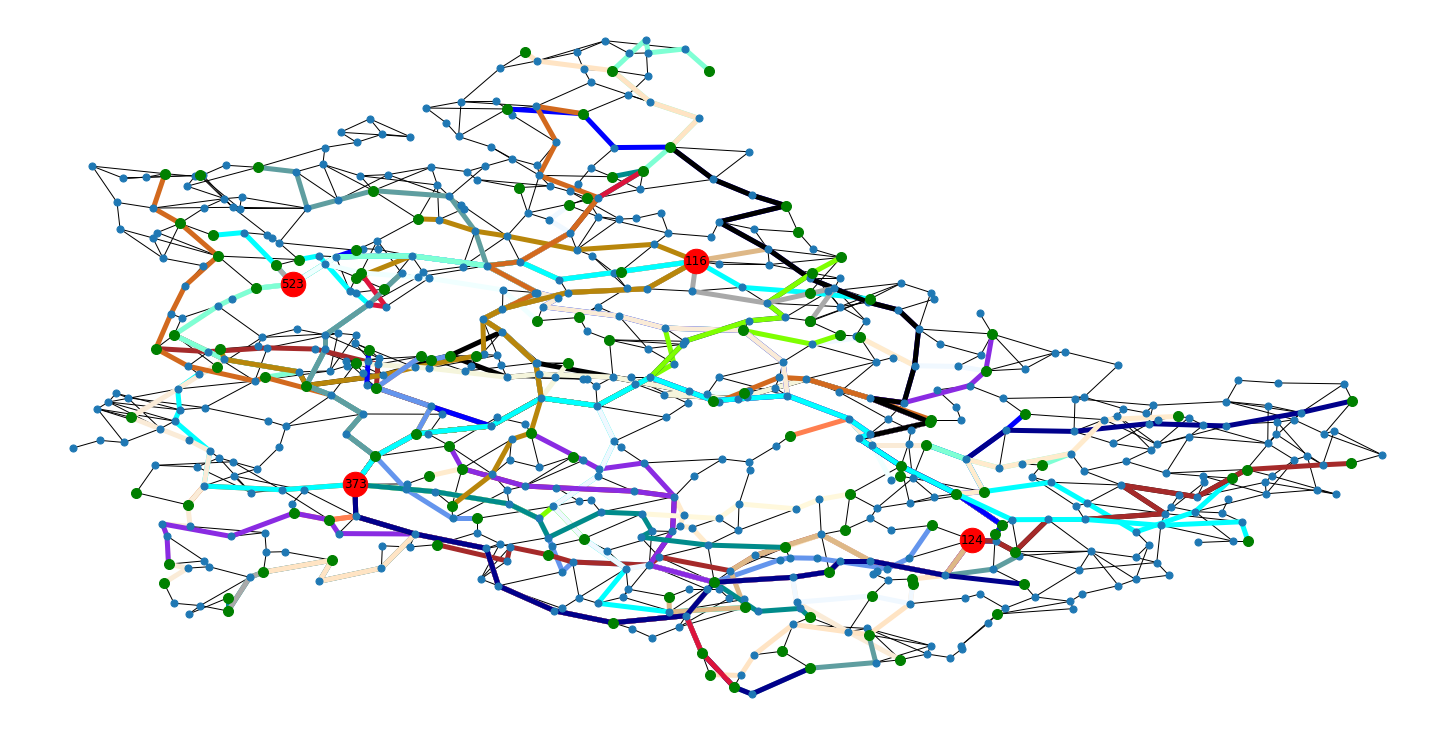

In [136]:
show_network()
# deliver to all low gas customers
gas_distances(plot=True);

In [205]:
# # write results to file
with open('problem2_sol.json', 'w') as f:
    json.dump(routes, f)

In [138]:
res = json.load(open('problem2_sol.json', 'r'))
res[:3]

[{'lorry_id': '523-0',
  'loc': [[523, 5], [32, -1.0], [64, -2.0], [80, -0.5], [124, 0]]},
 {'lorry_id': '523-1',
  'loc': [[523, 5], [63, -0.5], [205, -2.0], [446, -2.0], [124, 0]]},
 {'lorry_id': '523-2', 'loc': [[523, 12], [70, -1.5], [373, 0]]}]

In [139]:
validate_solution(routes, lorries_dict)

False

In [140]:
chromosomes_list = []
solutions_list = []

# Here we have used the genetic algorithm for optimization,

In [157]:
import random
from random import randrange
from time import time 


class Problem_Genetic(object):
    
    def __init__(self,genes,individuals_length,decode,fitness):
        self.genes= genes
        self.individuals_length= individuals_length
        self.decode= decode
        self.fitness= fitness

    def mutation(self, chromosome, prob):
            
            def inversion_mutation(chromosome_aux):
                chromosome = chromosome_aux
                
                index1 = randrange(0,len(chromosome))
                index2 = randrange(index1,len(chromosome))
                
                chromosome_mid = chromosome[index1:index2]
                chromosome_mid.reverse()
                
                chromosome_result = chromosome[0:index1] + chromosome_mid + chromosome[index2:]
                
                return chromosome_result
        
            aux = []
            for _ in range(len(chromosome)):
                if random.random() < prob :
                    aux = inversion_mutation(chromosome)
            return aux

    def crossover(self,parent1, parent2):

        def process_gen_repeated(copy_child1,copy_child2):
            count1=0
            for gen1 in copy_child1[:pos]:
                repeat = 0
                repeat = copy_child1.count(gen1)
                if repeat > 1:#If need to fix repeated gen
                    count2=0
                    for gen2 in parent1[pos:]:#Choose next available gen
                        if gen2 not in copy_child1:
                            child1[count1] = parent1[pos:][count2]
                        count2+=1
                count1+=1

            count1=0
            for gen1 in copy_child2[:pos]:
                repeat = 0
                repeat = copy_child2.count(gen1)
                if repeat > 1:#If need to fix repeated gen
                    count2=0
                    for gen2 in parent2[pos:]:#Choose next available gen
                        if gen2 not in copy_child2:
                            child2[count1] = parent2[pos:][count2]
                        count2+=1
                count1+=1

            return [child1,child2]

        pos=random.randrange(1,self.individuals_length-1)
        child1 = parent1[:pos] + parent2[pos:] 
        child2 = parent2[:pos] + parent1[pos:] 
        
        return  process_gen_repeated(child1, child2)
    
   
def decodeVRP(chromosome):    
    list=[]
    for (k,v) in chromosome:
        if k in trucks[:(num_trucks-1)]:
            list.append(frontier)
            continue
        list.append(cities.get(k))
    return list


def penalty_capacity(chromosome):
        actual = chromosome
        value_penalty = 0
        capacity_list = []
        index_cap = 0
        overloads = 0
        
        for i in range(0,len(trucks)):
            init = 0
            capacity_list.append(init)
            
        for (k,v) in actual:
            if k not in trucks:
                capacity_list[int(index_cap)]+=v
            else:
                index_cap+= 1
                
            if  capacity_list[index_cap] > capacity_trucks:
                overloads+=1
                value_penalty+= 100 * overloads
        return value_penalty

def fitnessVRP(chromosome):
    
    def distanceTrip(index,city):
        w = distances.get(index)
        return  w[city]
        
    actualChromosome = chromosome
#     print(actualChromosome)
    fitness_value = 0
   
    penalty_cap = penalty_capacity(actualChromosome)
    return 1




def genetic_algorithm_t(Problem_Genetic,k,opt,ngen,size,ratio_cross,prob_mutate):
    
    def initial_population(Problem_Genetic,size):   
        def generate_chromosome():
            chromosome=[]
            for i in Problem_Genetic.genes:
                chromosome.append(i)
            random.shuffle(chromosome)
            return chromosome
        return [generate_chromosome() for _ in range(size)]
            
    def new_generation_t(Problem_Genetic,k,opt,population,n_parents,n_directs,prob_mutate):
        
        def tournament_selection(Problem_Genetic,population,n,k,opt):
            winners=[]
            for _ in range(n):
                elements = random.sample(population,k)
                winners.append(opt(elements,key=Problem_Genetic.fitness))
            return winners
        
        def cross_parents(Problem_Genetic,parents):
            childs=[]
            for i in range(0,len(parents),2):
                childs.extend(Problem_Genetic.crossover(parents[i],parents[i+1]))
            return childs
    
        def mutate(Problem_Genetic,population,prob):
            for i in population:
                Problem_Genetic.mutation(i,prob)
            return population
                        
        directs = tournament_selection(Problem_Genetic, population, n_directs, k, opt)
        crosses = cross_parents(Problem_Genetic,
                                tournament_selection(Problem_Genetic, population, n_parents, k, opt))
        mutations = mutate(Problem_Genetic, crosses, prob_mutate)
        new_generation = directs + mutations
        
        return new_generation
    
    population = initial_population(Problem_Genetic, size)
    n_parents = round(size*ratio_cross)
    n_parents = (n_parents if n_parents%2==0 else n_parents-1)
    n_directs = size - n_parents
    
    for _ in range(ngen):
        population = new_generation_t(Problem_Genetic, k, opt, population, n_parents, n_directs, prob_mutate)
    
    bestChromosome = opt(population, key = Problem_Genetic.fitness)
    print("Chromosome: ", bestChromosome)
    chromosomes_list.append(bestChromosome)
    genotype = Problem_Genetic.decode(bestChromosome)
    print ("Solution: " , (genotype,Problem_Genetic.fitness(bestChromosome)))
    return (genotype,Problem_Genetic.fitness(bestChromosome))





def genetic_algorithm_t2(Problem_Genetic,k,opt,ngen,size,ratio_cross,prob_mutate,dictionary):
    
    def initial_population(Problem_Genetic,size):  
        
        def generate_chromosome():
            chromosome=[]
            for i in Problem_Genetic.genes:
                chromosome.append(i)
            random.shuffle(chromosome)
            #Adding to dictionary new generation
            dictionary[str(chromosome)]=1
            return chromosome
        
        return [generate_chromosome() for _ in range(size)]
            
    def new_generation_t(Problem_Genetic,k,opt,population,n_parents,n_directs,prob_mutate):
        def tournament_selection(Problem_Genetic,population,n,k,opt):
            winners = []
            for _ in range(int(n)):
                elements = random.sample(population,k)
                winners.append(opt(elements,key=Problem_Genetic.fitness))
            for winner in winners:
                #For each winner, if exists in dictionary, we increase his age
                if str(winner) in dictionary:
                    dictionary[str(winner)]=dictionary[str(winner)]+1
                else:
                    dictionary[str(winner)]=1
            return winners
        
        def cross_parents(Problem_Genetic,parents):
            childs=[]
            #Each time that some parent are crossed we add their two sons to dictionary 
            for i in range(0,len(parents),2):
                childs.extend(Problem_Genetic.crossover(parents[i],parents[i+1]))
                parent = str(parents[i])
                if parent not in dictionary:
                    dictionary[parent]=1
                    
                dictionary[str(childs[i])] = dictionary[parent]
                
                del dictionary[str(parents[i])]

            return childs
    
        def mutate(Problem_Genetic,population,prob):
            j = 0
            copy_population=population
            
            #Each time that some parent is crossed
            for crom in population:
                Problem_Genetic.mutation(crom,prob)
                
                parent = str(crom) 
                if parent in dictionary:
                    #We add the new chromosome mutated
                    dictionary[str(population[j])] = dictionary[parent]
                    
                    #remove old parent 
                    del dictionary[str(copy_population[j])]
                    j+=j
                    
            return population
        
        directs = tournament_selection(Problem_Genetic, population, n_directs, k, opt)
        crosses = cross_parents(Problem_Genetic,tournament_selection(Problem_Genetic, population, n_parents, k, opt))
        mutations = mutate(Problem_Genetic, crosses, prob_mutate)
        new_generation = directs + mutations
        
        #Adding new generation of mutants to dictionary.
        
        for ind in new_generation:
            age = 0
            crom = str(ind)
            if crom in dictionary:
                age+= 1
                dictionary[crom]+= 1
            else:
                dictionary[crom] = 1
        return new_generation
  
    population = initial_population(Problem_Genetic, size )
    n_parents= round(size*ratio_cross)
    n_parents = (n_parents if n_parents%2==0 else n_parents-1)
    n_directs = size - n_parents
    
    for _ in range(ngen):
        population = new_generation_t(Problem_Genetic, k, opt, population, n_parents, n_directs, prob_mutate)
        
    bestChromosome = opt(population, key = Problem_Genetic.fitness)
    print("Chromosome: ", bestChromosome)
    genotype = Problem_Genetic.decode(bestChromosome)
    print ("Solution:" , (genotype,Problem_Genetic.fitness(bestChromosome)),dictionary[(str(bestChromosome))] ," GENERATIONS.")
	
    return (genotype,Problem_Genetic.fitness(bestChromosome)
            + dictionary[(str(bestChromosome))]*50) #Updating fitness with age too
    


def VRP(k):
    
    
    temp = []
    nc = len(list(df_cust['id']))
    for i in list(df_cust['id']):
        temp.append((df_cust['id'][i], (df_cust['capacity'][i]-df_cust['level'][i])))
    temp.append((trucks[0],capacity_trucks))
    
    temp
    
    
    VRP_PROBLEM = Problem_Genetic(temp, len(cities), lambda x : decodeVRP(x), lambda y: fitnessVRP(y))
    
    def first_part_GA(k):
        cont  = 0
        print ("---------------------------------------------------------Executing FIRST PART: VRP --------------------------------------------------------- \n")
        print("Capacity of trucks = ",capacity_trucks)
        print("Frontier = ",frontier)
        print("")
        tiempo_inicial_t2 = time()
        while cont <= k: 
            genetic_algorithm_t(VRP_PROBLEM, 2, min, 200, 100, 0.8, 0.05)
            cont+=1
        tiempo_final_t2 = time()
        print("\n") 
        print("Total time: ",(tiempo_final_t2 - tiempo_inicial_t2)," secs.\n")
    
    def second_part_GA(k):
        print ("---------------------------------------------------------Executing SECOND PART: VRP --------------------------------------------------------- \n")
        print("Capacity of trucks = ",capacity_trucks)
        print("Frontier = ",frontier)
        print("")
        cont = 0
        tiempo_inicial_t2 = time()
        while cont <= k: 
            genetic_algorithm_t2(VRP_PROBLEM, 2, min, 200, 100, 0.8, 0.05,{})
            cont+=1
        tiempo_final_t2 = time()
        print("|n") 
        print("Total time: ",(tiempo_final_t2 - tiempo_inicial_t2)," secs.\n")
    
    
    first_part_GA(k)

# distances = {0:w0,1:w1,2:w2,3:w3,4:w4,5:w5,6:w6,7:w7, 8:w8}
cities = {}
for i in range(loc_len):
    cities[i] = i


distances = {}
# distances = {0:w0,1:w1,2:w2,3:w3,4:w4,5:w5,6:w6,7:w7, 8:w8}

for i in range(loc_len):
    distances[i] = dist_eucl[i]
    
capacity_trucks = 100
trucks = ['truck','truck']
num_trucks = len(trucks)
frontier = "---------"

if __name__ == "__main__":

    # Constant that is an instance object 
    genetic_problem_instances = 1
    print("EXECUTING ", genetic_problem_instances, " INSTANCES ")
    VRP(genetic_problem_instances)
    

EXECUTING  1  INSTANCES 
---------------------------------------------------------Executing FIRST PART: VRP --------------------------------------------------------- 

Capacity of trucks =  100
Frontier =  ---------

Chromosome:  [(624, 0.51), (474, 0.3999999999999999), (547, 0.95), ('truck', 100), (362, 0.75), (160, 0.91), (204, 0.69), (400, 0.19), (264, 0.8600000000000001), (389, 0.07), (77, 1.47), (374, 0.5), (175, 1.63), (431, 0.39), (80, 0.22999999999999998), (270, 0.21999999999999997), (598, 0.97), (411, 0.99), (82, 0.6), (393, 1.12), (235, 0.36), (497, 0.98), (437, 0.94), (64, 0.96), (455, 0.3), (41, 1.03), (274, 0.16999999999999993), (147, 0.8500000000000001), (113, 0.44999999999999996), (205, 0.9099999999999999), (110, 1.99), (308, 0.6799999999999999), (449, 1.74), (243, 0.6699999999999999), (146, 1.45), (245, 0.15000000000000002), (507, 1.15), (418, 0.32999999999999996), (210, 0.47), (569, 0.13), (70, 1.46), (398, 0.89), (491, 0.33999999999999997), (27, 1.02), (271, 0.9), (13

In [158]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in s:  
        str1 += ele   
    
    # return string   
    return str1  

In [159]:
print(chromosomes_list)
res = [''.join(ele) for ele in solutions_list] 


[[(455, 0.3), (418, 0.32999999999999996), (274, 0.16999999999999993), (534, 1.19), (332, 0.79), (147, 0.8500000000000001), (265, 0.48), (180, 0.76), (378, 0.54), (63, 0.47), ('truck', 100), (31, 0.56), (206, 0.88), (78, 0.63), (70, 1.46), (446, 0.94), (175, 1.63), (308, 0.6799999999999999), (476, 0.31000000000000005), (393, 1.12), (453, 0.61), (144, 0.45999999999999996), (73, 0.22999999999999998), (497, 0.98), (624, 0.51), (13, 0.19999999999999996), (80, 0.22999999999999998), (29, 0.54), (100, 1.02), (519, 0.21000000000000002), (82, 0.6), (364, 0.89), (65, 0.72), (377, 0.95), (408, 0.28), (491, 0.33999999999999997), (633, 0.18000000000000005), (260, 1.62), (550, 0.45999999999999996), (391, 1.0), (539, 0.28), (449, 1.74), (94, 1.52), (130, 1.19), (172, 0.91), (621, 0.24), (584, 0.21999999999999997), (190, 0.3600000000000001), (431, 0.39), (44, 0.71), (324, 0.42000000000000004), (243, 0.6699999999999999), (41, 1.03), (5, 0.09999999999999998), (220, 0.61), (387, 1.24), (216, 0.27), (264, 

In [168]:
print(len(chromosomes_list))

4


In [169]:
final_order = chromosomes_list[-1]

In [170]:

avg_cap = 13
avg_cos = 1.5
avg_fue = 1.0


In [171]:
def calculate_cost(f, d):
    return d*(avg_cos + f*avg_fue)

In [187]:
dist_graph[116, 260]


491.0407116586781

In [202]:
n = len(final_order)
total_distance = 0
total_fuel = 0
for i in range(n-1):
    print(final_order[i])
    if final_order[i+1][0] != 'truck' and final_order[i][0] != 'truck':
        total_distance += dist_graph[final_order[i][0], final_order[i+1][0]]
        total_fuel += (final_order[i][1] + final_order[i+1][1])
total_distance /=2

(543, 0.54)
(397, 0.7)
(180, 0.76)
(110, 1.99)
(175, 1.63)
(632, 1.24)
(136, 0.33999999999999997)
(324, 0.42000000000000004)
(418, 0.32999999999999996)
(183, 0.3999999999999999)
(531, 0.10999999999999999)
(380, 0.15999999999999998)
(362, 0.75)
(22, 1.68)
(41, 1.03)
(411, 0.99)
(100, 1.02)
(539, 0.28)
(255, 0.16999999999999998)
(274, 0.16999999999999993)
(491, 0.33999999999999997)
(171, 1.3199999999999998)
(550, 0.45999999999999996)
(146, 1.45)
(519, 0.21000000000000002)
(449, 1.74)
(210, 0.47)
(65, 0.72)
(103, 0.43999999999999995)
(86, 1.03)
(177, 1.23)
(374, 0.5)
(542, 0.47)
(29, 0.54)
(243, 0.6699999999999999)
(520, 0.44)
(63, 0.47)
(276, 0.9299999999999999)
(598, 0.97)
(455, 0.3)
(70, 1.46)
(64, 0.96)
(606, 1.44)
(453, 0.61)
(391, 1.0)
(584, 0.21999999999999997)
(214, 1.6099999999999999)
(190, 0.3600000000000001)
(389, 0.07)
(511, 0.24)
(144, 0.45999999999999996)
(507, 1.15)
(633, 0.18000000000000005)
(78, 0.63)
(364, 0.89)
(204, 0.69)
(32, 0.92)
(77, 1.47)
(172, 0.91)
(235, 0.36)
(

In [200]:
print("Total Cost ---- ", calculate_cost(total_fuel, total_distance))


Total Cost ----  4057875.1243698364


In [201]:
print("mileage ---  ", total_distance/total_fuel)
miles_travelled = total_distance/total_fuel

mileage ---   126.66270753002433
